In [1]:
# About The model and approach : In this model i have user pearson correlation method to generate list of similar users
# and show recommendations based on similar users. 
# Since the dataset is large and my system is unable to process that large data i have divided the dataset into two parts
# first part will be consisting of users 1 to 26000 and other part consisting users 26001 and above 
# In this model we can evaluate similar users for the first 1 to 26000 users but i can also evaluate other users by 
# using same approach.
# The idea for showing this approach is i want to create a hybrid recommendation system that uses both collaborative filtering
# and content based filtering. 

# Instruction : Just replace the user id( range from 1 to 26000) in the Enter user id section of this notebook to check
# working of this approach i have tested working by using user id 1.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats

import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
# No missing data
ratings.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [5]:
print('The ratings dataset has ', ratings['user_id'].nunique(), ' unique users')
print('The ratings dataset has ', ratings['book_id'].nunique(), ' unique books')
print('The ratings dataset has ', ratings['rating'].nunique(), ' unique ratings')

print('The unique ratings are ', sorted(ratings['rating'].unique()))

The ratings dataset has  53424  unique users
The ratings dataset has  10000  unique books
The ratings dataset has  5  unique ratings
The unique ratings are  [1, 2, 3, 4, 5]


In [6]:
books = pd.read_csv('books.csv')
books.head()
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [7]:
# using book_id as matching key we can merge the two tables
df = pd.merge(ratings, books, on='book_id', how='inner')
df.head()

,user_id,book_id,rating,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
1,11,258,3,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
2,143,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
3,242,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
4,325,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...


# EXLORING DATA ANALYSIS

In [8]:
# keeping only those books with over 1000 rating for the analysis
agg_ratings = df.groupby('title').agg(mean_rating=('rating','mean'),no_of_ratings=('rating','count')).reset_index()
agg_rating_GT500 = agg_ratings[agg_ratings['no_of_ratings']>1000]

agg_rating_GT500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229 entries, 3 to 9877
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1229 non-null   object 
 1   mean_rating    1229 non-null   float64
 2   no_of_ratings  1229 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 38.4+ KB


In [9]:
table = agg_rating_GT500.sort_values(by = 'no_of_ratings',ascending= False)

In [10]:
table['no_of_ratings'].sum()
table['mean_rating'].sum()

4808.477168215071

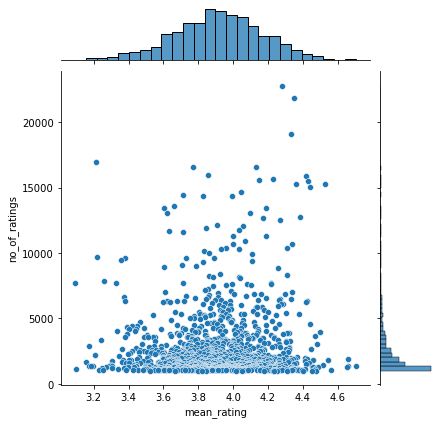

In [11]:
# VISUALISATION OF DATA
sns.jointplot(x='mean_rating', y = 'no_of_ratings', data = table)

In [12]:
df_GT500 = pd.merge(df,agg_rating_GT500[['title']], on ='title' ,how ='inner')

In [13]:
# to keep books only rated 1000+ ratings
df_GT500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3431037 entries, 0 to 3431036
Data columns (total 25 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   book_id                    int64  
 2   rating                     int64  
 3   goodreads_book_id          int64  
 4   best_book_id               int64  
 5   work_id                    int64  
 6   books_count                int64  
 7   isbn                       object 
 8   isbn13                     float64
 9   authors                    object 
 10  original_publication_year  float64
 11  original_title             object 
 12  title                      object 
 13  language_code              object 
 14  average_rating             float64
 15  ratings_count              int64  
 16  work_ratings_count         int64  
 17  work_text_reviews_count    int64  
 18  ratings_1                  int64  
 19  ratings_2                  int64  
 20  ra

In [14]:
# checking unique values
df_GT500['user_id'].nunique()

53415

In [15]:
# creating user book matrix
matrix = df_GT500.pivot_table(index = 'user_id', columns='title' ,values = 'rating')

In [16]:
matrix.head()

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,Wonder,"Wool Omnibus (Silo, #1)","Words of Radiance (The Stormlight Archive, #2)",World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# normalising matrix
normal_matrix = matrix.subtract(matrix.mean(axis = 1),axis = 'rows')
normal_matrix.head()

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,Wonder,"Wool Omnibus (Silo, #1)","Words of Radiance (The Stormlight Archive, #2)",World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,0.446809,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.446809,NaN,NaN,0.446809,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.183673,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.224000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
print('Total negative values in first row ', (normal_matrix.loc[[1]] < 0).sum().sum())
print('Total positive values in first row ', (normal_matrix.loc[[1]] > 0).sum().sum())
print('Total null values in first row', normal_matrix.loc[[1]].isna().sum().sum())

Total negative values in first row  47
Total positive values in first row  47
Total null values in first row 1135


In [19]:
# fill null values of matrix by -9
normal_matrix = normal_matrix.fillna(-9)
normal_matrix.head()

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,Wonder,"Wool Omnibus (Silo, #1)","Words of Radiance (The Stormlight Archive, #2)",World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
1,-9.0,-9.0,-9.0,0.446809,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,-9.0,-9.0,0.446809,-9.0,-9.0,0.446809,-9.0,-9.0
2,-9.0,-9.0,-9.0,-9.000000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,-9.0,-9.0,-9.000000,-9.0,-9.0,-9.000000,-9.0,-9.0
3,-9.0,-9.0,-9.0,0.183673,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,-9.0,-9.0,-9.000000,-9.0,-9.0,-9.000000,-9.0,-9.0
4,-9.0,-9.0,-9.0,0.224000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,-9.0,-9.0,-9.000000,-9.0,-9.0,-9.000000,-9.0,-9.0
5,-9.0,-9.0,-9.0,-9.000000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,-9.0,-9.0,-9.000000,-9.0,-9.0,-9.000000,-9.0,-9.0


In [20]:
#user_similarity_pearson = normal_matrix.astype('uint8').T.corr()
#normal_matrix.dtypes
#normal_matrix['user_id'].astype('float_16')
#normal_matrix.dtypes

#normal_matrix['user_id'] = normal_matrix['user_id'].astype('uint8')
#user_similarity = normal_matrix.T.corr()

# dividing normal matrix into two halves
normal_matrix1 = normal_matrix.iloc[:26000,:]
normal_matrix2 = normal_matrix.iloc[26000:,:]

normal_matrix1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 1 to 26004
Columns: 1229 entries, 'Salem's Lot to Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
dtypes: float64(1229)
memory usage: 244.0 MB


In [21]:
 normal_matrix2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27415 entries, 26005 to 53424
Columns: 1229 entries, 'Salem's Lot to Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
dtypes: float64(1229)
memory usage: 257.3 MB


In [22]:
user_similarity1 = normal_matrix1.T.corr()

In [23]:
user_similarity1.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,25995,25996,25997,25998,25999,26000,26001,26002,26003,26004
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.072868,0.079517,0.206966,-0.003888,0.069023,0.008426,0.107814,0.198353,0.259042,...,0.244208,-0.003408,0.075255,0.060404,-0.021585,-0.008154,0.130777,0.126141,-0.025531,-0.041897
2,0.072868,1.000000,0.038217,0.217313,-0.027236,0.019229,0.022977,0.082746,0.163179,0.123924,...,0.028145,0.133709,0.051223,0.002219,-0.013767,0.151242,0.147735,0.163126,0.186959,-0.026721
3,0.079517,0.038217,1.000000,0.133527,-0.030289,0.030052,0.103392,0.161186,0.096532,0.073850,...,0.031221,0.015110,0.030632,0.055503,-0.015310,-0.019130,0.144873,0.142843,-0.020678,-0.029716
4,0.206966,0.217313,0.133527,1.000000,-0.035143,0.017857,0.127496,0.174589,0.206511,0.153538,...,0.047290,0.115209,0.169100,0.090809,-0.025224,0.083189,0.181450,0.203153,0.153825,-0.030227
5,-0.003888,-0.027236,-0.030289,-0.035143,1.000000,-0.029266,-0.039116,-0.010636,-0.030128,-0.025765,...,0.045309,-0.015881,-0.039410,0.054185,-0.011259,0.072816,0.084236,-0.031259,-0.029742,-0.021853


In [23]:
user_similarity2 = normal_matrix2.T.corr()

In [24]:
user_similarity2.head()

user_id,26005,26006,26007,26008,26009,26010,26011,26012,26013,26014,...,53415,53416,53417,53418,53419,53420,53421,53422,53423,53424
user_id,,,,,,,,,,,,,,,,,,,,,
26005,1.000000,-0.041039,0.064097,-0.015120,-0.038062,0.047527,-0.024289,-0.022653,0.012635,0.037858,...,0.092338,-0.029069,0.046123,-0.026166,0.194550,0.127567,0.032726,0.019035,-0.005796,-0.037824
26006,-0.041039,1.000000,-0.042169,0.057778,0.043657,0.051057,0.028090,0.152359,0.043369,0.067757,...,-0.019395,-0.026782,-0.005690,0.015703,0.029318,0.064916,0.028960,0.183307,0.081130,0.003551
26007,0.064097,-0.042169,1.000000,-0.001466,0.031524,0.198827,0.014976,0.012300,0.077735,0.057035,...,0.065532,-0.025612,-0.019545,-0.015405,0.197076,0.101303,0.091747,0.089539,0.008251,0.030055
26008,-0.015120,0.057778,-0.001466,1.000000,0.143114,0.053257,-0.028462,0.121896,-0.024120,-0.030371,...,0.023478,-0.020920,0.162487,0.139934,0.060677,0.035443,0.029229,0.155650,0.111132,0.135996
26009,-0.038062,0.043657,0.031524,0.143114,1.000000,0.041458,-0.019353,0.160686,0.005497,0.047613,...,0.170634,-0.026914,0.130206,-0.020381,0.039587,0.072602,0.048601,0.143810,0.156284,0.070034


### Enter user id here just replace picked_user_id = 2 with picked_user_id you want (1 to 26000) 

In [25]:
#checking for user 2 
picked_user_id = 2
user_similarity1.drop(index = picked_user_id,inplace = True)

user_similarity1.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,25995,25996,25997,25998,25999,26000,26001,26002,26003,26004
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.072868,0.079517,0.206966,-0.003888,0.069023,0.008426,0.107814,0.198353,0.259042,...,0.244208,-0.003408,0.075255,0.060404,-0.021585,-0.008154,0.130777,0.126141,-0.025531,-0.041897
3,0.079517,0.038217,1.000000,0.133527,-0.030289,0.030052,0.103392,0.161186,0.096532,0.073850,...,0.031221,0.015110,0.030632,0.055503,-0.015310,-0.019130,0.144873,0.142843,-0.020678,-0.029716
4,0.206966,0.217313,0.133527,1.000000,-0.035143,0.017857,0.127496,0.174589,0.206511,0.153538,...,0.047290,0.115209,0.169100,0.090809,-0.025224,0.083189,0.181450,0.203153,0.153825,-0.030227
5,-0.003888,-0.027236,-0.030289,-0.035143,1.000000,-0.029266,-0.039116,-0.010636,-0.030128,-0.025765,...,0.045309,-0.015881,-0.039410,0.054185,-0.011259,0.072816,0.084236,-0.031259,-0.029742,-0.021853
6,0.069023,0.019229,0.030052,0.017857,-0.029266,1.000000,0.007295,0.048044,0.099727,0.084797,...,0.037226,-0.008818,-0.022269,0.013223,-0.014793,-0.003756,0.004910,-0.020581,0.009447,-0.028712


In [26]:
# now we will get 10 most similar user for this id
n = 10
user_similarity_threshold = 0.3
similar_users = user_similarity1[user_similarity1[picked_user_id] > user_similarity_threshold][picked_user_id]
print('Similar Users for user are' , similar_users)

Similar Users for user are user_id
21       0.389054
58       0.311236
125      0.308730
176      0.323813
187      0.312252
           ...   
25383    0.321562
25539    0.313505
25559    0.302868
25582    0.324701
25755    0.351031
Name: 2, Length: 207, dtype: float64


In [28]:
similar_users.head(n)

user_id
21     0.389054
58     0.311236
125    0.308730
176    0.323813
187    0.312252
190    0.304599
255    0.344630
305    0.313138
354    0.374621
386    0.314877
Name: 2, dtype: float64

In [29]:
picked_userid_watched = normal_matrix1[normal_matrix1.index == picked_user_id].dropna(axis = 1,how = 'all')
picked_userid_watched

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,Wonder,"Wool Omnibus (Silo, #1)","Words of Radiance (The Stormlight Archive, #2)",World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
2,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [30]:
normal_matrix1.replace('-9.0', None)

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,Wonder,"Wool Omnibus (Silo, #1)","Words of Radiance (The Stormlight Archive, #2)",World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
1,-9.0,-9.000000,-9.0,0.446809,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,0.446809,-9.000000,-9.0,0.446809,-9.000000,-9.0
2,-9.0,-9.000000,-9.0,-9.000000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,-9.000000,-9.0,-9.000000,-9.000000,-9.0
3,-9.0,-9.000000,-9.0,0.183673,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,-9.000000,-9.0,-9.000000,-9.000000,-9.0
4,-9.0,-9.000000,-9.0,0.224000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,-9.000000,-9.0,-9.000000,-9.000000,-9.0
5,-9.0,-9.000000,-9.0,-9.000000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,-9.000000,-9.0,-9.000000,-9.000000,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26000,-9.0,0.574074,-9.0,-9.000000,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,-9.000000,-9.0,-9.000000,-1.425926,-9.0
26001,-9.0,0.982609,-9.0,-0.017391,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-0.017391,-9.000000,-9.000000,-9.00000,-9.000000,0.982609,-9.0,-9.000000,-1.017391,-9.0
26002,-9.0,-9.000000,-9.0,0.057692,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,...,-9.000000,-9.000000,-9.000000,-9.00000,-9.000000,-9.000000,-9.0,-9.000000,-9.000000,-9.0


In [31]:
# normalising matrix
normal_matrix_withNaN = matrix.subtract(matrix.mean(axis = 1),axis = 'rows')

In [32]:
# dividing matrix into two equal halves
normal_matrix1_withNaN = normal_matrix_withNaN.iloc[:26000,:]
normal_matrix2_withNaN = normal_matrix_withNaN.iloc[26000:,:]

In [33]:
picked_userid_watched = normal_matrix1_withNaN[normal_matrix1_withNaN.index == picked_user_id].dropna(axis = 1,how = 'all')
picked_userid_watched

title,America (The Book): A Citizen's Guide to Democracy Inaction,Blink: The Power of Thinking Without Thinking,Breakfast at Tiffany's,Do Androids Dream of Electric Sheep?,Gone with the Wind,Great Expectations,Hamlet,"Harry Potter and the Chamber of Secrets (Harry Potter, #2)","Harry Potter and the Deathly Hallows (Harry Potter, #7)","Harry Potter and the Goblet of Fire (Harry Potter, #4)",...,The Grapes of Wrath,The Great Gatsby,"The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",The Joy Luck Club,The Little Prince,"The Secret (The Secret, #1)",The Sun Also Rises,The Tipping Point: How Little Things Can Make a Big Difference,Tuesdays with Morrie,Who Moved My Cheese?
user_id,,,,,,,,,,,,,,,,,,,,,
2,-1.45,0.55,-0.45,0.55,-1.45,0.55,-0.45,0.55,0.55,0.55,...,0.55,0.55,0.55,-0.45,0.55,-2.45,-1.45,0.55,0.55,-1.45


In [34]:
similar_user_movies = normal_matrix1_withNaN[normal_matrix1_withNaN.index.isin(similar_users.index)].dropna(axis = 1,how = 'all')
similar_user_movies

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,"Wolf Hall (Thomas Cromwell, #1)","Wolves of the Calla (The Dark Tower, #5)",Wonder,World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,0.211538,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.211538,NaN,NaN,0.211538,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,0.159091,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.835443,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25559,NaN,NaN,NaN,0.432432,0.432432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
similar_user_movies.drop(picked_userid_watched.columns, axis = 1, inplace = True, errors = 'ignore')
similar_user_movies

title,'Salem's Lot,11/22/63,1776,1984,1Q84,"1st to Die (Women's Murder Club, #1)","2001: A Space Odyssey (Space Odyssey, #1)",A Bend in the Road,"A Breath of Snow and Ashes (Outlander, #6)",A Brief History of Time,...,"Wolf Hall (Thomas Cromwell, #1)","Wolves of the Calla (The Dark Tower, #5)",Wonder,World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,Yes Please,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values
user_id,,,,,,,,,,,,,,,,,,,,,
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,0.211538,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.211538,NaN,NaN,0.211538,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,0.159091,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.835443,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25559,NaN,NaN,NaN,0.432432,0.432432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## RECOMMENDING USER BOOKS THROUGH SIMILAR USERS

In [38]:
item_score = {}

for i in similar_user_movies.columns:
    movie_rating = similar_user_movies[i]
    total = 0 
    count = 0
    for u in similar_users.index:
        if pd.isna(movie_rating[u]) == False:
            score = similar_users[u]*movie_rating[u]
            total += score
            count += 1
    item_score[i] = total/count
item_score = pd.DataFrame(item_score.items(), columns = ['books','books_score'])
ranked_item_score = item_score.sort_values(by = 'books_score', ascending = False)

recommendation1 = ranked_item_score.head(5)
recommendation1.head()

,books,books_score
399,Midwives,0.535791
585,"The Blade Itself (The First Law, #1)",0.524481
578,The Bad Beginning (A Series of Unfortunate Eve...,0.502903
171,"Dark Lover (Black Dagger Brotherhood, #1)",0.497724
371,"Lover Awakened (Black Dagger Brotherhood, #3)",0.497724


In [39]:
# We can make a function to recommend books 
# Here i have splitted the parts of users into two matrix of around equal parts because of me personal computer configuration 
# issues as memory is exceeding in this system
# in example i have taken used id 2 to recommend some results based on similar user interest

# def recommendUsingUserFilter(u_id):
#     if u_id <= 26004:
#         picked_user_id = u_id
#         user_similarity1.drop(index = picked_user_id,inplace = True)
#         user_similarity1 = normal_matrix1.T.corr()
#         user_similarity_threshold = 0.3
#         similar_users = user_similarity1[user_similarity1[picked_user_id] > user_similarity_threshold][picked_user_id]
#         picked_userid_watched = normal_matrix1_withNaN[normal_matrix1_withNaN.index == picked_user_id].dropna(axis = 1,how = 'all')
#         similar_user_movies = normal_matrix1_withNaN[normal_matrix1_withNaN.index.isin(similar_users.index)].dropna(axis = 1,how = 'all')
#         similar_user_movies.drop(picked_userid_watched.columns, axis = 1, inplace = True, errors = 'ignore')
#         item_score = {}

#         for i in similar_user_movies.columns:
#             movie_rating = similar_user_movies[i]
#             total = 0 
#             count = 0
#             for u in similar_users.index:
#                 if pd.isna(movie_rating[u]) == False:
#                     score = similar_users[u]*movie_rating[u]
#                     total += score
#                     count += 1
#             item_score[i] = total/count
#         item_score = pd.DataFrame(item_score.items(), columns = ['books','books_score'])
#         ranked_item_score = item_score.sort_values(by = 'books_score', ascending = False)

#         recommendation1 = ranked_item_score.head(5)
#         return recommendation1
#     else:
#         picked_user_id = u_id
#         user_similarity2.drop(index = picked_user_id,inplace = True)
#         user_similarity2 = normal_matrix2.T.corr()
#         user_similarity_threshold = 0.3
#         similar_users = user_similarity2[user_similarity2[picked_user_id] > user_similarity_threshold][picked_user_id]
#         picked_userid_watched = normal_matrix2_withNaN[normal_matrix2_withNaN.index == picked_user_id].dropna(axis = 1,how = 'all')
#         similar_user_movies = normal_matrix2_withNaN[normal_matrix2_withNaN.index.isin(similar_users.index)].dropna(axis = 1,how = 'all')
#         similar_user_movies.drop(picked_userid_watched.columns, axis = 1, inplace = True, errors = 'ignore')
#         item_score = {}

#         for i in similar_user_movies.columns:
#             movie_rating = similar_user_movies[i]
#             total = 0 
#             count = 0
#             for u in similar_users.index:
#                 if pd.isna(movie_rating[u]) == False:
#                     score = similar_users[u]*movie_rating[u]
#                     total += score
#                     count += 1
#             item_score[i] = total/count
#         item_score = pd.DataFrame(item_score.items(), columns = ['books','books_score'])
#         ranked_item_score = item_score.sort_values(by = 'books_score', ascending = False)

#         recommendation1 = ranked_item_score.head(5)
#         return recommendation1 
    
        